# Evaluating Tikhonet Trained

In this Notebook we are going to evaluate the performance of a [Tikhonet](https://arxiv.org/pdf/1911.00443.pdf) trained.

## Required Libraries and Functions

In [1]:
%matplotlib inline
import sys

# Add library path to PYTHONPATH
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)
data_path = './'

# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# Functions
def draw_table(text_list):
    part1 = """\\begin{table}[h!]
\\resizebox{\\textwidth}{!}{
\\begin{tabular}{|l||l|l|l|l|}
\hline
"""
    part2 = """{0} & {1}  & {2} & {3} & {4} \\\ \hline
{5} & {6}  & {7} & {8} & {9} \\\\
{10} & {11}  & {12} & {13} & {14} \\\\
{15} & {16}  & {17} & {18} & {19} \\\\
{20} & {21}  & {22} & {23} & {24} \\\\
{25} & {26}  & {27} & {28} & {29} \\\\
{30} & {31}  & {32} & {33} & {34} \\\ \hline
""".format(*text_list)
    
    part3 = """\end{tabular}
}
\end{table}"""
    
    return part1+part2+part3
    
def latex_float(f):
    float_str = "{:.2e}".format(f)
    base, exponent = float_str.split("e")
    base = list(base)
    base[1+1*(f<0)] = ','
    base = "".join(base)
    return r"{0} . 10^{{{1}}}".format(base, int(exponent))

def latex_float_err(value,err):
    return r'${0} \pm {1}$'.format(latex_float(value),latex_float(err))

## Load the Evaluation Dataset

In [2]:
f = open(data_path+"meerkat3600_data.pkl", "rb")
data = pickle.load(f)
f.close()

In [3]:
data.keys()

dict_keys(['flux', 'mse_abs', 'mse_rel', 'mom', 'windows', 'window_flags', 'sigma_flags', 'snr'])

In [4]:
data['flux'].keys()

dict_keys(['sparsity', 'score', 'tikhonet', 'tikhonet_sc', 'clean', 'clean_iso', 'true'])

### Load data and compute errors

In [5]:
snr = data['snr']

# load pixel errors
mse_g0 = data['mse_abs']['tikhonet']
mse_g05 = data['mse_abs']['tikhonet_sc']
mse_cl_iso = data['mse_abs']['clean_iso']
mse_cl = data['mse_abs']['clean']
mse_s0 = data['mse_abs']['sparsity']
mse_s2 = data['mse_abs']['score']

# load relative pixel errors
mse_g0_rel = data['mse_rel']['tikhonet']
mse_g05_rel = data['mse_rel']['tikhonet_sc']
mse_cl_iso_rel = data['mse_rel']['clean_iso']
mse_cl_rel = data['mse_rel']['clean']
mse_s0_rel = data['mse_rel']['sparsity']
mse_s2_rel = data['mse_rel']['score']

# load moments
mom_g0 = data['mom']['tikhonet']
mom_g05 = data['mom']['tikhonet_sc']
mom_cl_iso = data['mom']['clean_iso']
mom_cl = data['mom']['clean']
mom_s0 = data['mom']['sparsity']
mom_s2 = data['mom']['score']
mom_true,windows, window_flags = data['mom']['true'], data['windows'], data['window_flags']

# load flux
flux_g0 = data['flux']['tikhonet']
flux_g05 = data['flux']['tikhonet_sc']
flux_cl_iso = data['flux']['clean_iso']
flux_cl = data['flux']['clean']
flux_s0 = data['flux']['sparsity']
flux_s2 = data['flux']['score']
flux_true = data['flux']['true']

In [6]:
# compute adapative moments errors
mom_err_g0 = np.abs(mom_g0-mom_true)
mom_err_g05 = np.abs(mom_g05-mom_true)
mom_err_cl_iso = np.abs(mom_cl_iso-mom_true)
mom_err_cl = np.abs(mom_cl-mom_true)
mom_err_s0 = np.abs(mom_s0-mom_true)
mom_err_s2 = np.abs(mom_s2-mom_true)

#compute flux relative errors
flux_err_g0 = np.abs(flux_g0 - flux_true) / flux_true
flux_err_g05 = np.abs(flux_g05 - flux_true) /flux_true
flux_err_cl = np.abs(flux_cl - flux_true) / flux_true
flux_err_cl_iso = np.abs(flux_cl_iso - flux_true) /flux_true
flux_err_s0 = np.abs(flux_s0 - flux_true) / flux_true
flux_err_s2 = np.abs(flux_s2 - flux_true) /flux_true

In [7]:
# MAKING SNR BINS
# Binning parameters
n_bins = 4

# BEGIN BINNING
# Partition galaxies into bins of equal size
# Initialize lower bound
lower_bound = np.min(snr)
ind_list = []
bins = []
sqrt_num_gal = []

for i in range(n_bins-1):
    # compute quantile that is used as an upper bound
    q = np.quantile(snr,(i+1)/n_bins)
    # retrieve galaxy indices which magnitude are between the bounds
    cond = np.logical_and(lower_bound<=snr,snr<q)
    ind = np.arange(cond.size)[cond]
    sqrt_num_gal += [np.sqrt(cond.sum())]
    # retrieve corresponding objects
    snr_q = snr[ind]
    ind_list += [ind]
    print(i+1, q, np.mean(snr_q))
    bins += [np.mean(snr_q)]
    # update lower bound
    lower_bound = q
# retrieve last bin indices
cond = lower_bound<=snr
ind = np.arange(cond.size)[cond]
# retrieve corresponding objects
snr_q = snr[ind]
ind_list += [ind]
sqrt_num_gal += [np.sqrt(cond.sum())]
bins += [np.mean(snr_q)]
print(i+2, q, np.mean(snr_q))

# END BINNING

1 5.757177702968617 4.378329972179469
2 8.294482686076222 6.919606640432914
3 12.207562119655655 9.9853122079986
4 12.207562119655655 16.738446122311043


In [8]:
# computing mean and standard deviation of relative mse error per binned SNR

mse_mean_g0 = []
mse_mean_g05 = []
mse_mean_cl_iso = []
mse_mean_cl = []
mse_mean_s0 = []
mse_mean_s2 = []

mse_std_g0 = []
mse_std_g05 = []
mse_std_cl_iso = []
mse_std_cl = []
mse_std_s0 = []
mse_std_s2 = []

mse_mean_g0_rel = []
mse_mean_g05_rel = []
mse_mean_cl_iso_rel = []
mse_mean_cl_rel = []
mse_mean_s0_rel = []
mse_mean_s2_rel = []

mse_std_g0_rel = []
mse_std_g05_rel = []
mse_std_cl_iso_rel = []
mse_std_cl_rel = []
mse_std_s0_rel = []
mse_std_s2_rel = []

# computing mean and standard deviation of adapative moments error per binned SNR

mom_mean_g0 = []
mom_mean_g05 = []
mom_mean_cl_iso = []
mom_mean_cl = []
mom_mean_s0 = []
mom_mean_s2 = []

mom_median_g0 = []
mom_median_g05 = []
mom_median_cl_iso = []
mom_median_cl = []
mom_median_s0 = []
mom_median_s2 = []

mom_std_g0 = []
mom_std_g05 = []
mom_std_cl_iso = []
mom_std_cl = []
mom_std_s0 = []
mom_std_s2 = []

# computing mean and standard deviation of relative flux error per binned SNR

flux_mean_g0 = []
flux_mean_g05 = []
flux_mean_cl_iso = []
flux_mean_cl = []
flux_mean_s0 = []
flux_mean_s2 = []

flux_std_g0 = []
flux_std_g05 = []
flux_std_cl_iso = []
flux_std_cl = []
flux_std_s0 = []
flux_std_s2 = []

for ind in ind_list:
    
    mse_mean_g0 += [np.mean(mse_g0[ind])]
    mse_mean_g05 += [np.mean(mse_g05[ind])]
    mse_mean_cl_iso += [np.mean(mse_cl_iso[ind])]
    mse_mean_cl += [np.mean(mse_cl[ind])]
    mse_mean_s0 += [np.mean(mse_s0[ind])]
    mse_mean_s2 += [np.mean(mse_s2[ind])]

    mse_std_g0 += [np.std(mse_g0[ind])]
    mse_std_g05 += [np.std(mse_g05[ind])]
    mse_std_cl_iso += [np.std(mse_cl_iso[ind])]
    mse_std_cl += [np.std(mse_cl[ind])]
    mse_std_s0 += [np.std(mse_s0[ind])]
    mse_std_s2 += [np.std(mse_s2[ind])]
    
    mse_mean_g0_rel += [np.mean(mse_g0_rel[ind])]
    mse_mean_g05_rel += [np.mean(mse_g05_rel[ind])]
    mse_mean_cl_iso_rel += [np.mean(mse_cl_iso_rel[ind])]
    mse_mean_cl_rel += [np.mean(mse_cl_rel[ind])]
    mse_mean_s0_rel += [np.mean(mse_s0_rel[ind])]
    mse_mean_s2_rel += [np.mean(mse_s2_rel[ind])]

    mse_std_g0_rel += [np.std(mse_g0_rel[ind])]
    mse_std_g05_rel += [np.std(mse_g05_rel[ind])]
    mse_std_cl_iso_rel += [np.std(mse_cl_iso_rel[ind])]
    mse_std_cl_rel += [np.std(mse_cl_rel[ind])]
    mse_std_s0_rel += [np.std(mse_s0_rel[ind])]
    mse_std_s2_rel += [np.std(mse_s2_rel[ind])]
    
    mom_mean_g0 += [np.mean(np.abs(mom_err_g0[:,ind]),axis=1)]
    mom_mean_g05 += [np.mean(np.abs(mom_err_g05[:,ind]),axis=1)]
    mom_mean_cl_iso += [np.mean(np.abs(mom_err_cl_iso[:,ind]),axis=1)]
    mom_mean_cl += [np.mean(np.abs(mom_err_cl[:,ind]),axis=1)]
    mom_mean_s0 += [np.mean(np.abs(mom_err_s0[:,ind]),axis=1)]
    mom_mean_s2 += [np.mean(np.abs(mom_err_s2[:,ind]),axis=1)]
    
    mom_median_g0 += [np.median(np.abs(mom_err_g0[:,ind]),axis=1)]
    mom_median_g05 += [np.median(np.abs(mom_err_g05[:,ind]),axis=1)]
    mom_median_cl_iso += [np.median(np.abs(mom_err_cl_iso[:,ind]),axis=1)]
    mom_median_cl += [np.median(np.abs(mom_err_cl[:,ind]),axis=1)]
    mom_median_s0 += [np.median(np.abs(mom_err_s0[:,ind]),axis=1)]
    mom_median_s2 += [np.median(np.abs(mom_err_s2[:,ind]),axis=1)]

    mom_std_g0 += [np.std(np.abs(mom_err_g0[:,ind]),axis=1)]
    mom_std_g05 += [np.std(np.abs(mom_err_g05[:,ind]),axis=1)]
    mom_std_cl_iso += [np.std(np.abs(mom_err_cl_iso[:,ind]),axis=1)]
    mom_std_cl += [np.std(np.abs(mom_err_cl[:,ind]),axis=1)]
    mom_std_s0 += [np.std(np.abs(mom_err_s0[:,ind]),axis=1)]
    mom_std_s2 += [np.std(np.abs(mom_err_s2[:,ind]),axis=1)]
    
    flux_mean_g0 += [np.mean(flux_err_g0[ind])]
    flux_mean_g05 += [np.mean(flux_err_g05[ind])]
    flux_mean_cl_iso += [np.mean(flux_err_cl_iso[ind])]
    flux_mean_cl += [np.mean(flux_err_cl[ind])]
    flux_mean_s0 += [np.mean(flux_err_s0[ind])]
    flux_mean_s2 += [np.mean(flux_err_s2[ind])]

    flux_std_g0 += [np.std(flux_err_g0[ind])]
    flux_std_g05 += [np.std(flux_err_g05[ind])]
    flux_std_cl_iso += [np.std(flux_err_cl_iso[ind])]
    flux_std_cl += [np.std(flux_err_cl[ind])]
    flux_std_s0 += [np.std(flux_err_s0[ind])]
    flux_std_s2 += [np.std(flux_err_s2[ind])]
    
# Convert to numpy array with shape (2, n_bins)

mse_mean_g0 = np.array(mse_mean_g0).T
mse_mean_g05 = np.array(mse_mean_g05).T
mse_mean_cl_iso = np.array(mse_mean_cl_iso).T
mse_mean_cl = np.array(mse_mean_cl).T
mse_mean_s0 = np.array(mse_mean_s0).T
mse_mean_s2 = np.array(mse_mean_s2).T

mse_std_g0 = np.array(mse_std_g0).T
mse_std_g05 = np.array(mse_std_g05).T
mse_std_cl_iso = np.array(mse_std_cl_iso).T
mse_std_cl = np.array(mse_std_cl).T
mse_std_s0 = np.array(mse_std_s0).T
mse_std_s2 = np.array(mse_std_s2).T

mse_mean_g0_rel = np.array(mse_mean_g0_rel).T
mse_mean_g05_rel = np.array(mse_mean_g05_rel).T
mse_mean_cl_iso_rel = np.array(mse_mean_cl_iso_rel).T
mse_mean_cl_rel = np.array(mse_mean_cl_rel).T
mse_mean_s0_rel = np.array(mse_mean_s0_rel).T
mse_mean_s2_rel = np.array(mse_mean_s2_rel).T

mse_std_g0_rel = np.array(mse_std_g0_rel).T
mse_std_g05_rel = np.array(mse_std_g05_rel).T
mse_std_cl_iso_rel = np.array(mse_std_cl_iso_rel).T
mse_std_cl_rel = np.array(mse_std_cl_rel).T
mse_std_s0_rel = np.array(mse_std_s0_rel).T
mse_std_s2_rel = np.array(mse_std_s2_rel).T

mom_mean_g0 = np.array(mom_mean_g0).T
mom_mean_g05 = np.array(mom_mean_g05).T
mom_mean_cl_iso = np.array(mom_mean_cl_iso).T
mom_mean_cl = np.array(mom_mean_cl).T
mom_mean_s0 = np.array(mom_mean_s0).T
mom_mean_s2 = np.array(mom_mean_s2).T

mom_median_g0 = np.array(mom_median_g0).T
mom_median_g05 = np.array(mom_median_g05).T
mom_median_cl_iso = np.array(mom_median_cl_iso).T
mom_median_cl = np.array(mom_median_cl).T
mom_median_s0 = np.array(mom_median_s0).T
mom_median_s2 = np.array(mom_median_s2).T

mom_std_g0 = np.array(mom_std_g0).T
mom_std_g05 = np.array(mom_std_g05).T
mom_std_cl_iso = np.array(mom_std_cl_iso).T
mom_std_cl = np.array(mom_std_cl).T
mom_std_s0 = np.array(mom_std_s0).T
mom_std_s2 = np.array(mom_std_s2).T

flux_mean_g0 = np.array(flux_mean_g0).T
flux_mean_g05 = np.array(flux_mean_g05).T
flux_mean_cl_iso = np.array(flux_mean_cl_iso).T
flux_mean_cl = np.array(flux_mean_cl).T
flux_mean_s0 = np.array(flux_mean_s0).T
flux_mean_s2 = np.array(flux_mean_s2).T

flux_std_g0 = np.array(flux_std_g0).T
flux_std_g05 = np.array(flux_std_g05).T
flux_std_cl_iso = np.array(flux_std_cl_iso).T
flux_std_cl = np.array(flux_std_cl).T
flux_std_s0 = np.array(flux_std_s0).T
flux_std_s2 = np.array(flux_std_s2).T

<ipython-input-9-edc310b30523>:50: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(bottom=0)


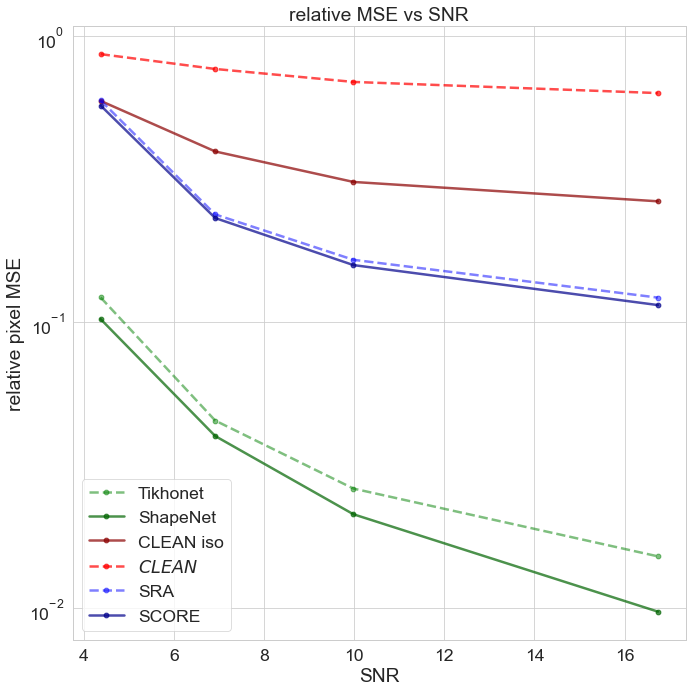

In [9]:
# set seaborn theme and style
sns.set_theme()
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})
#remove grid from images
sns.set_style("whitegrid")#, {'axes.grid' : False})

color_g0 = 'green'
color_g05 = 'darkgreen'
color_cl = 'red'
color_cl_iso = 'darkred'
color_s0 = 'blue'
color_s2 = 'darkblue'

label_cl_iso = r'CLEAN iso'
label_cl = r'$CLEAN$'
label_s0 = r'SRA'
label_s2 = r'SCORE'
label_g0 = r'Tikhonet'
label_g05 = r'ShapeNet'

# plt.figure(figsize=(10,10))
# # plt.errorbar(bins,mse_mean_g0,mse_std_g0/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# # plt.errorbar(bins,mse_mean_g05,mse_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# # plt.errorbar(bins,mse_mean_cl_iso,mse_std_cl_iso/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
# # plt.errorbar(bins,mse_mean_cl,mse_std_cl/sqrt_num_gal,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
# plt.semilogy(bins,mse_mean_g0,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,mse_mean_g05,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.semilogy(bins,mse_mean_cl_iso,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
# plt.semilogy(bins,mse_mean_cl,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
# plt.ylim(bottom=0)
# #plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
# plt.xlabel(r'SNR')
# plt.ylabel(r'pixel MSE')
# plt.title(r'absolute MSE vs SNR')
# plt.legend()
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(10,10))
# plt.errorbar(bins,mse_mean_g0_rel,mse_std_g0_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.errorbar(bins,mse_mean_g05_rel,mse_std_g05_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.errorbar(bins,mse_mean_cl_iso_rel,mse_std_cl_iso_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
# plt.errorbar(bins,mse_mean_cl_rel,mse_std_cl_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.semilogy(bins,mse_mean_g0_rel,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.semilogy(bins,mse_mean_g05_rel,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.semilogy(bins,mse_mean_cl_iso_rel,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
plt.semilogy(bins,mse_mean_cl_rel,linestyle='--', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.semilogy(bins,mse_mean_s0_rel,linestyle='--', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.semilogy(bins,mse_mean_s2_rel,linestyle='-', marker='o',color=color_s2,label=label_s2,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'relative pixel MSE')
plt.title(r'relative MSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

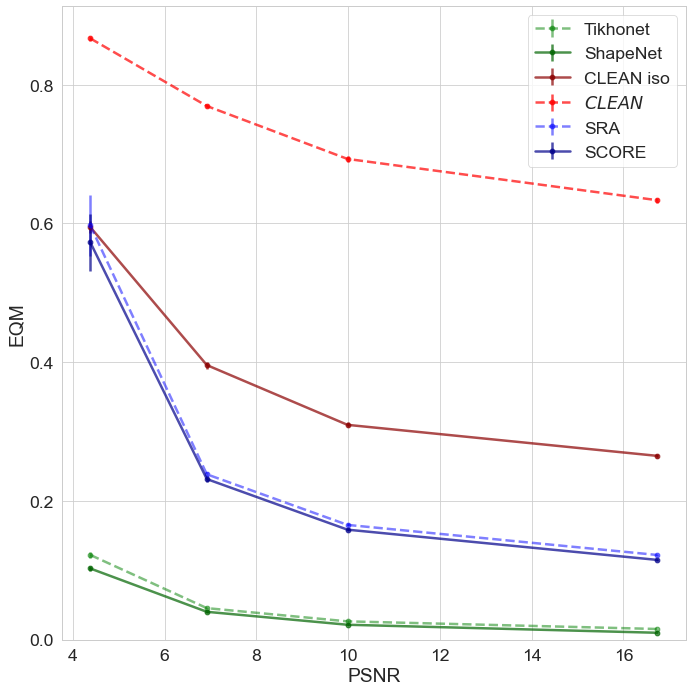

In [10]:
# plt.figure(figsize=(10,10))
# plt.errorbar(bins,mse_mean_g0,mse_std_g0/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.errorbar(bins,mse_mean_g05,mse_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.errorbar(bins,mse_mean_cl_iso,mse_std_cl_iso/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
# plt.errorbar(bins,mse_mean_cl,mse_std_cl/sqrt_num_gal,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
# # plt.semilogy(bins,mse_mean_g0,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# # plt.semilogy(bins,mse_mean_g05,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# # plt.semilogy(bins,mse_mean_cl_iso,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
# # plt.semilogy(bins,mse_mean_cl,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
# plt.ylim(bottom=0)
# #plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
# plt.xlabel(r'SNR')
# plt.ylabel(r'pixel MSE')
# plt.title(r'absolute MSE vs SNR')
# plt.legend()
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mse_mean_g0_rel,mse_std_g0_rel/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mse_mean_g05_rel,mse_std_g05_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,mse_mean_cl_iso_rel,mse_std_cl_iso_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
plt.errorbar(bins,mse_mean_cl_rel,mse_std_cl_rel/sqrt_num_gal,linestyle='--', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.errorbar(bins,mse_mean_s0_rel,mse_std_s0_rel/sqrt_num_gal,linestyle='--', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mse_mean_s2_rel,mse_std_s2_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_s2,label=label_s2,alpha=0.7)
# plt.semilogy(bins,mse_mean_g0_rel,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,mse_mean_g05_rel,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.semilogy(bins,mse_mean_cl_iso_rel,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
# plt.semilogy(bins,mse_mean_cl_rel,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'PSNR')
plt.ylabel(r'EQM')
# plt.title(r'relative MSE vs SNR')
plt.legend()
plt.tight_layout()
# plt.show()
plt.savefig('./meerkat_mse.pdf')

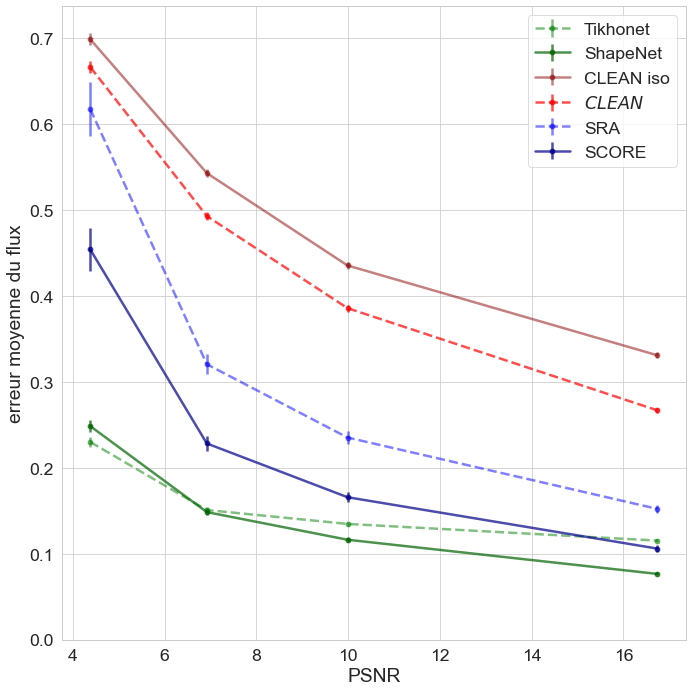

In [11]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,flux_mean_g0,flux_std_g0/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,flux_mean_g05,flux_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,flux_mean_cl_iso,flux_std_cl/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.5)
plt.errorbar(bins,flux_mean_cl,flux_std_cl_iso/sqrt_num_gal,linestyle='--', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.errorbar(bins,flux_mean_s0,flux_std_s0/sqrt_num_gal,linestyle='--', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,flux_mean_s2,flux_std_s2/sqrt_num_gal,linestyle='-', marker='o',color=color_s2,label=label_s2,alpha=0.7)
# plt.semilogy(bins,flux_mean_g0,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,flux_mean_g05,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.semilogy(bins,flux_mean_cl_iso,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.5)
# plt.semilogy(bins,flux_mean_cl,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'PSNR')
plt.ylabel(r'erreur moyenne du flux')
# plt.title(r'Relative flux vs SNR')
plt.legend()
plt.tight_layout()
# plt.show()
plt.savefig('./meerkat_flux.pdf')

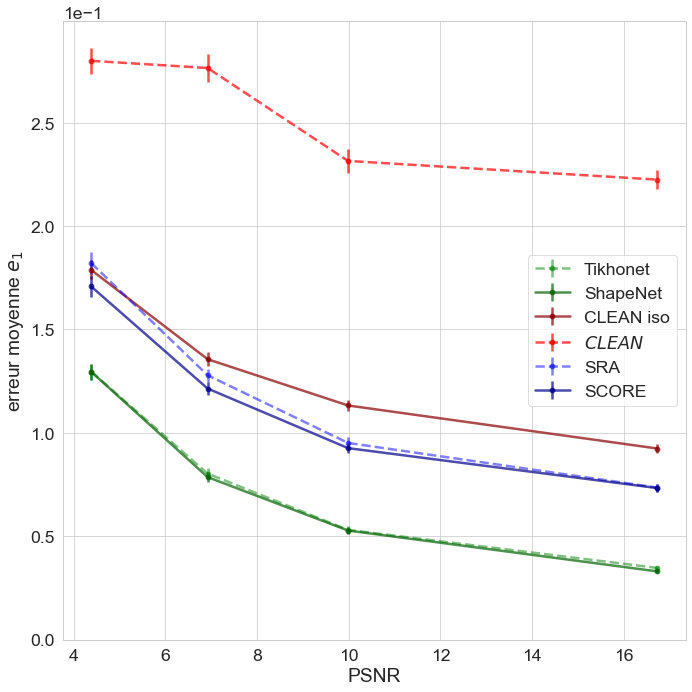

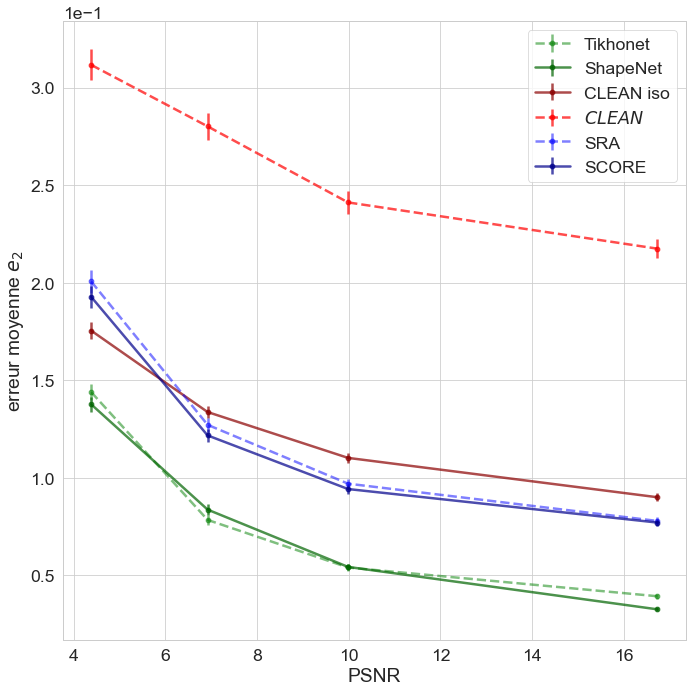

In [12]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[0],mom_std_g0[0]/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[0],mom_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,mom_mean_cl_iso[0],mom_std_cl_iso[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
plt.errorbar(bins,mom_mean_cl[0],mom_std_cl[0]/sqrt_num_gal,linestyle='--', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.errorbar(bins,mom_mean_s0[0],mom_std_s0[0]/sqrt_num_gal,linestyle='--', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_mean_s2[0],mom_std_s2[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s2,label=label_s2,alpha=0.7)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'PSNR')
plt.ylabel(r'erreur moyenne $e_{1}$')
# plt.title(r'$e_1$ absolute mean RMSE vs SNR')
plt.legend()
plt.tight_layout()
# plt.show()
plt.savefig('./meerkat_e1.pdf')

plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[1],mom_std_g0[1]/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[1],mom_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,mom_mean_cl_iso[1],mom_std_cl_iso[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
plt.errorbar(bins,mom_mean_cl[1],mom_std_cl[1]/sqrt_num_gal,linestyle='--', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.errorbar(bins,mom_mean_s0[1],mom_std_s0[1]/sqrt_num_gal,linestyle='--', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_mean_s2[1],mom_std_s2[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s2,label=label_s2,alpha=0.7)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'PSNR')
plt.ylabel(r'erreur moyenne $e_2$')
# plt.title(r'$e_2$ absolute mean RMSE vs SNR')
plt.legend()
plt.tight_layout()
# plt.show()
plt.savefig('./meerkat_e2.pdf')

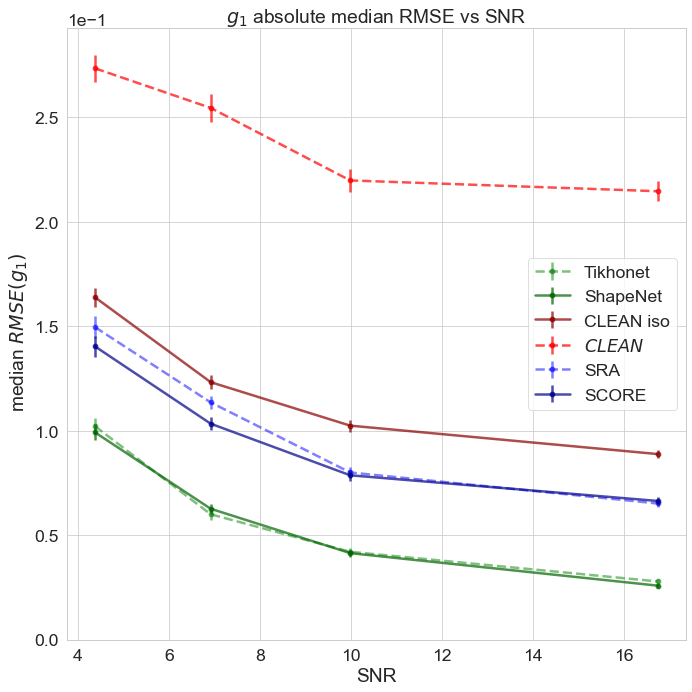

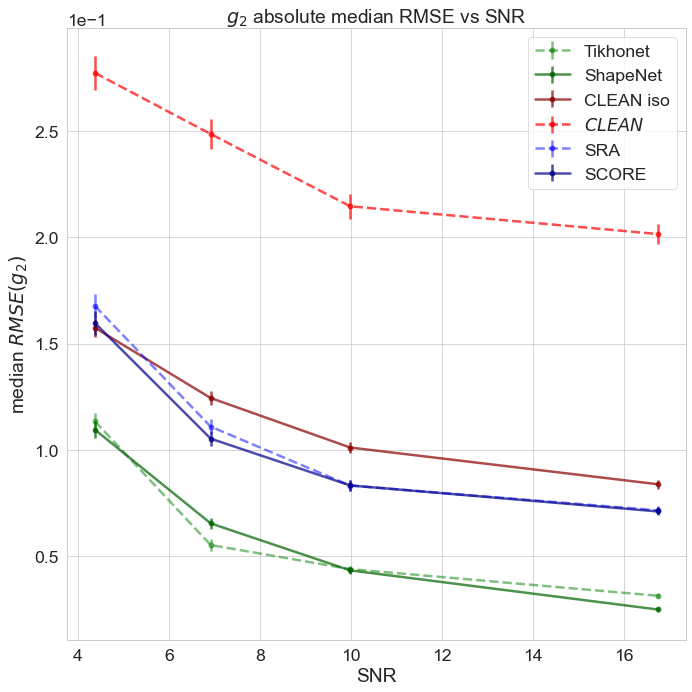

In [13]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_median_g0[0],mom_std_g0[0]/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_median_g05[0],mom_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,mom_median_cl_iso[0],mom_std_cl_iso[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
plt.errorbar(bins,mom_median_cl[0],mom_std_cl[0]/sqrt_num_gal,linestyle='--', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.errorbar(bins,mom_median_s0[0],mom_std_s0[0]/sqrt_num_gal,linestyle='--', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_median_s2[0],mom_std_s2[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s2,label=label_s2,alpha=0.7)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r' median $RMSE(g_{1})$')
plt.title(r'$g_1$ absolute median RMSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_median_g0[1],mom_std_g0[1]/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_median_g05[1],mom_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,mom_median_cl_iso[1],mom_std_cl_iso[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
plt.errorbar(bins,mom_median_cl[1],mom_std_cl[1]/sqrt_num_gal,linestyle='--', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.errorbar(bins,mom_median_s0[1],mom_std_s0[1]/sqrt_num_gal,linestyle='--', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_median_s2[1],mom_std_s2[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s2,label=label_s2,alpha=0.7)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'median $RMSE(g_2)$')
plt.title(r'$g_2$ absolute median RMSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

### Make table for global performance

In [14]:
n_batch = window_flags.size
sqrt_n_batch = np.sqrt(n_batch)

# compute absolute pixel errors
mse_g0_mean = np.mean(mse_g0)
mse_s2_mean = np.mean(mse_s2)
mse_s0_mean = np.mean(mse_s0)
mse_g05_mean = np.mean(mse_g05)
mse_cl_mean = np.mean(mse_cl)
mse_cl_iso_mean = np.mean(mse_cl_iso)

mse_g0_std = np.std(mse_g0)/sqrt_n_batch
mse_s2_std = np.std(mse_s2)/sqrt_n_batch
mse_s0_std = np.std(mse_s0)/sqrt_n_batch
mse_g05_std = np.std(mse_g05)/sqrt_n_batch
mse_cl_std = np.std(mse_cl)/sqrt_n_batch
mse_cl_iso_std = np.std(mse_cl_iso)/sqrt_n_batch

# compute relative pixel errors
mse_rel_g0_mean = np.mean(mse_g0_rel)
mse_rel_s2_mean = np.mean(mse_s2_rel)
mse_rel_s0_mean = np.mean(mse_s0_rel)
mse_rel_g05_mean = np.mean(mse_g05_rel)
mse_rel_cl_mean = np.mean(mse_cl_rel)
mse_rel_cl_iso_mean = np.mean(mse_cl_iso_rel)

mse_rel_g0_std = np.std(mse_g0_rel)/sqrt_n_batch
mse_rel_s2_std = np.std(mse_s2_rel)/sqrt_n_batch
mse_rel_s0_std = np.std(mse_s0_rel)/sqrt_n_batch
mse_rel_g05_std = np.std(mse_g05_rel)/sqrt_n_batch
mse_rel_cl_std = np.std(mse_cl_rel)/sqrt_n_batch
mse_rel_cl_iso_std = np.std(mse_cl_iso_rel)/sqrt_n_batch

# compute adapative moments errors
mom1_err_g0_mean = np.mean(mom_err_g0[0])
mom1_err_s2_mean = np.mean(mom_err_s2[0])
mom1_err_s0_mean = np.mean(mom_err_s0[0])
mom1_err_g05_mean = np.mean(mom_err_g05[0])
mom1_err_cl_mean = np.mean(mom_err_cl[0])
mom1_err_cl_iso_mean = np.mean(mom_err_cl_iso[0])

mom1_err_g0_std = np.std(mom_err_g0[0])/sqrt_n_batch
mom1_err_s2_std = np.std(mom_err_s2[0])/sqrt_n_batch
mom1_err_s0_std = np.std(mom_err_s0[0])/sqrt_n_batch
mom1_err_g05_std = np.std(mom_err_g05[0])/sqrt_n_batch
mom1_err_cl_std = np.std(mom_err_cl[0])/sqrt_n_batch
mom1_err_cl_iso_std = np.std(mom_err_cl_iso[0])/sqrt_n_batch

mom2_err_g0_mean = np.mean(mom_err_g0[1])
mom2_err_s2_mean = np.mean(mom_err_s2[1])
mom2_err_s0_mean = np.mean(mom_err_s0[1])
mom2_err_g05_mean = np.mean(mom_err_g05[1])
mom2_err_cl_mean = np.mean(mom_err_cl[1])
mom2_err_cl_iso_mean = np.mean(mom_err_cl_iso[1])

mom2_err_g0_std = np.std(mom_err_g0[1])/sqrt_n_batch
mom2_err_s2_std = np.std(mom_err_s2[1])/sqrt_n_batch
mom2_err_s0_std = np.std(mom_err_s0[1])/sqrt_n_batch
mom2_err_g05_std = np.std(mom_err_g05[1])/sqrt_n_batch
mom2_err_cl_std = np.std(mom_err_cl[1])/sqrt_n_batch
mom2_err_cl_iso_std = np.std(mom_err_cl_iso[1])/sqrt_n_batch

# compute fluxipticity errors
flux_err_g0_mean = np.mean(np.abs(flux_err_g0))
flux_err_s2_mean = np.mean(np.abs(flux_err_s2))
flux_err_s0_mean = np.mean(np.abs(flux_err_s0))
flux_err_g05_mean = np.mean(np.abs(flux_err_g05))
flux_err_cl_mean = np.mean(np.abs(flux_err_cl))
flux_err_cl_iso_mean = np.mean(np.abs(flux_err_cl_iso))

flux_err_g0_std = np.std(np.abs(flux_err_g0))/sqrt_n_batch
flux_err_s2_std = np.std(np.abs(flux_err_s2))/sqrt_n_batch
flux_err_s0_std = np.std(np.abs(flux_err_s0))/sqrt_n_batch
flux_err_g05_std = np.std(np.abs(flux_err_g05))/sqrt_n_batch
flux_err_cl_std = np.std(np.abs(flux_err_cl))/sqrt_n_batch
flux_err_cl_iso_std = np.std(np.abs(flux_err_cl_iso))/sqrt_n_batch

In [15]:
header = ["M\\'{e}thodes", 'EQM', 'flux', '$e_1$', '$e_2$']
methods = ['CLEAN', 'CLEAN iso', 'SRA', 'SCORE', 'Tikhonet', 'Tikhonet CF']
means = [mse_rel_cl_mean,mse_rel_cl_iso_mean,mse_rel_s0_mean,mse_rel_s2_mean,mse_rel_g0_mean,mse_rel_g05_mean,
         flux_err_cl_mean,flux_err_cl_iso_mean,flux_err_s0_mean,flux_err_s2_mean,flux_err_g0_mean,flux_err_g05_mean,
         mom1_err_cl_mean,mom1_err_cl_iso_mean,mom1_err_s0_mean,mom1_err_s2_mean,mom1_err_g0_mean,mom1_err_g05_mean,
         mom2_err_cl_mean,mom2_err_cl_iso_mean,mom2_err_s0_mean,mom2_err_s2_mean,mom2_err_g0_mean,mom2_err_g05_mean]
stds = [mse_rel_cl_std,mse_rel_cl_iso_std,mse_rel_s0_std,mse_rel_s2_std,mse_rel_g0_std,mse_rel_g05_std,
        flux_err_cl_std,flux_err_cl_iso_std,flux_err_s0_std,flux_err_s2_std,flux_err_g0_std,flux_err_g05_std,
        mom1_err_cl_std,mom1_err_cl_iso_std,mom1_err_s0_std,mom1_err_s2_std,mom1_err_g0_std,mom1_err_g05_std,
        mom2_err_cl_std,mom2_err_cl_iso_std,mom2_err_s0_std,mom2_err_s2_std,mom2_err_g0_std,mom2_err_g05_std]

text_list = header + []

for ind,method in enumerate(methods):
    text_list += [method]
    for j in range(4):
        text_list += [latex_float_err(means[6*j+ind],stds[6*j+ind])]

print(draw_table(text_list))

\begin{table}[h!]
\resizebox{\textwidth}{!}{
\begin{tabular}{|l||l|l|l|l|}
\hline
M\'{e}thodes & EQM  & flux & $e_1$ & $e_2$ \\ \hline
CLEAN & $7,41 . 10^{-1} \pm 2,37 . 10^{-3}$  & $4,53 . 10^{-1} \pm 3,62 . 10^{-3}$ & $2,53 . 10^{-1} \pm 2,97 . 10^{-3}$ & $2,63 . 10^{-1} \pm 3,31 . 10^{-3}$ \\
CLEAN iso & $3,91 . 10^{-1} \pm 3,51 . 10^{-3}$  & $5,02 . 10^{-1} \pm 3,47 . 10^{-3}$ & $1,30 . 10^{-1} \pm 1,76 . 10^{-3}$ & $1,27 . 10^{-1} \pm 1,70 . 10^{-3}$ \\
SRA & $2,81 . 10^{-1} \pm 1,16 . 10^{-2}$  & $3,31 . 10^{-1} \pm 9,30 . 10^{-3}$ & $1,20 . 10^{-1} \pm 1,87 . 10^{-3}$ & $1,26 . 10^{-1} \pm 2,07 . 10^{-3}$ \\
SCORE & $2,69 . 10^{-1} \pm 1,08 . 10^{-2}$  & $2,39 . 10^{-1} \pm 7,15 . 10^{-3}$ & $1,14 . 10^{-1} \pm 1,78 . 10^{-3}$ & $1,21 . 10^{-1} \pm 2,01 . 10^{-3}$ \\
Tikhonet & $5,21 . 10^{-2} \pm 1,47 . 10^{-3}$  & $1,58 . 10^{-1} \pm 2,14 . 10^{-3}$ & $7,44 . 10^{-2} \pm 1,44 . 10^{-3}$ & $7,88 . 10^{-2} \pm 1,53 . 10^{-3}$ \\
Tikhonet CF & $4,33 . 10^{-2} \pm 1,17 . 10^{-3}$ 

In [16]:
bins

[4.378329972179469, 6.919606640432914, 9.9853122079986, 16.738446122311043]

In [17]:
data['sigma_flags'].size,data['sigma_flags'].sum()

(3072, 3000)